## Quora Question Pairs

### Business Problem

**1. Description**

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


**Credits**: Kaggle

### Problem Statement

Identify which questions asked on Quora are duplicates of questions that have already been asked.
This could be useful to instantly provide answers to questions that have already been answered.
We are tasked with predicting whether a pair of questions are duplicates or not.

### Machine Learning Problem

#### Data Overview
- Data will be in a file Train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of Train.csv - 60MB 
- Number of rows in Train.csv = 404,290

#### Example Data point
"id","qid1","qid2","question1","question2","is_duplicate"

"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"

"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"

"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"

"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"


#### Type of Machine Leaning Problem
It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

#### Performance Metric
**Source**: https://www.kaggle.com/c/quora-question-pairs#evaluation

**Metric(s)**:

log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
Binary Confusion Matrix

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

### Reading data from CSV file

In [4]:
df = pd.read_csv("train.csv")
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

* id: Looks like a simple rowID
* qid{1, 2}: The unique ID of each question in the pair
* question{1, 2}: The actual textual contents of the questions.
* is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

### Distribution of data points among output classes
#### Number of duplicate(smilar) and non-duplicate(non similar) questions

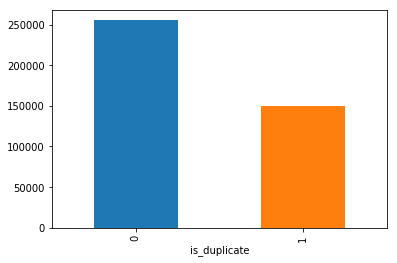

In [5]:
df.groupby('is_duplicate')['id'].count().plot(kind='bar')

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


### Number of unique questions

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



In [9]:
qids.value_counts().head()

2559     157
30782    120
4044     111
2561      88
14376     79
dtype: int64

In [10]:
df['question1'][df['qid1']==2559].head()

14712    What are the best ways to lose weight?
38200    What are the best ways to lose weight?
56239    What are the best ways to lose weight?
81363    What are the best ways to lose weight?
81973    What are the best ways to lose weight?
Name: question1, dtype: object

### Plot representing unique and repeated questions

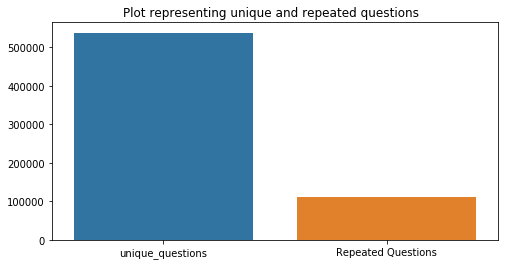

In [11]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(8, 4))
plt.title ("Plot representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

### Checking for Duplicates

In [12]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### Plot of the log-histogram of question appearence counts

Maximum number of times a single question is repeated: 157



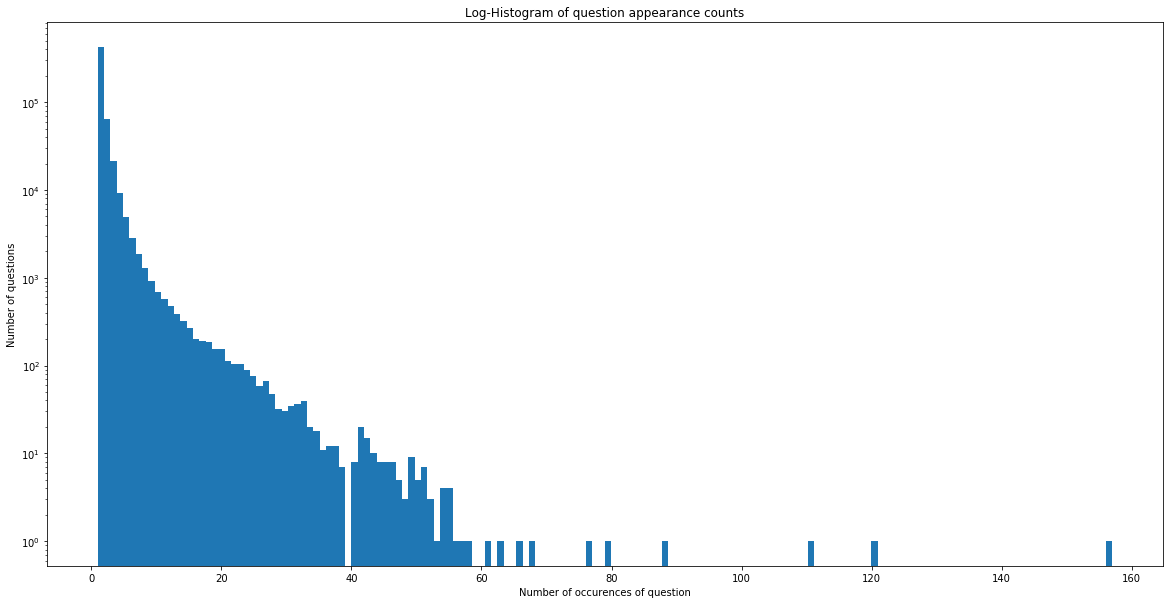

In [13]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [14]:
list(q_vals).count(40)

8

### Checking for any NaN rows

In [15]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [16]:
df.isnull().any()

id              False
qid1            False
qid2            False
question1        True
question2        True
is_duplicate    False
dtype: bool

In [17]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


### Basic Feature Extraction (before cleaning)

Let us now construct a few features like:

* freq_qid1 = Frequency of qid1's
* freq_qid2 = Frequency of qid2's
* q1len = Length of q1
* q2len = Length of q2
* q1_n_words = Number of words in Question 1
* q2_n_words = Number of words in Question 2
* word_Common = (Number of common unique words in Question 1 and Question 2)
* word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
* word_share = (word_common)/(word_Total)
* freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [18]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len1,q2len1,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Analysis of the minimum and maximum length of questions

In [19]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


### Plots of the word_share in duplicate and non-duplicate questions

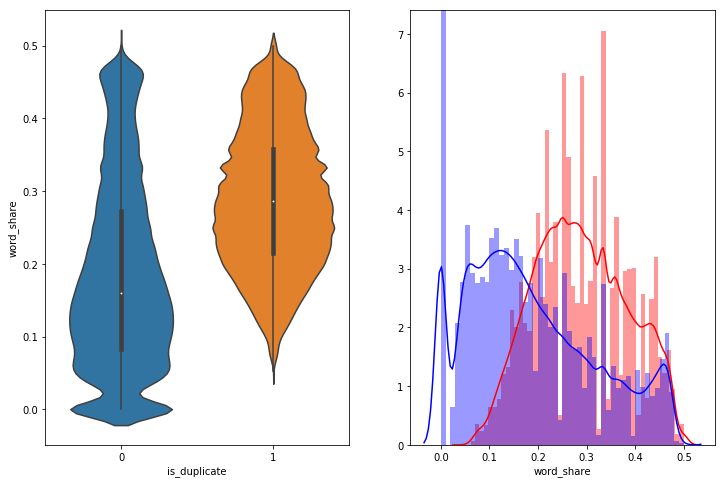

In [20]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][:] , label = "0" , color = 'blue' )
plt.show()

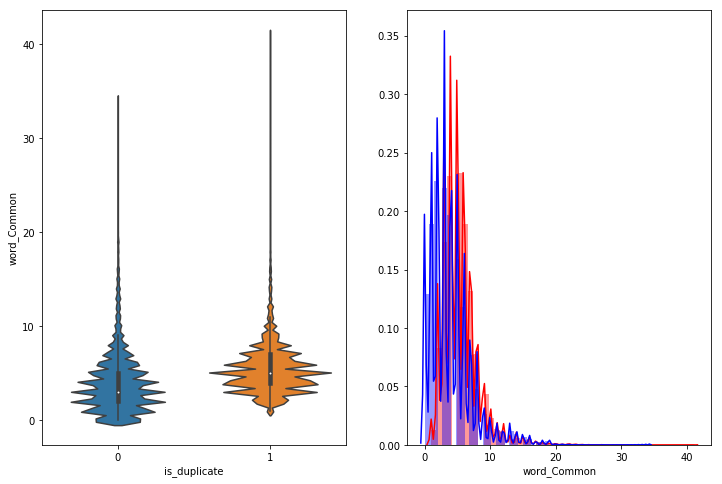

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][:] , label = "0" , color = 'blue' )
plt.show()

### EDA: Advanced Feature Extraction.

In [22]:
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [23]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [24]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1len1,q2len1,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


### Preprocessing of Text
* Preprocessing:
  * Removing html tags
  * Removing Punctuations
  * Performing stemming
  * Removing Stopwords
  * Expanding contractions etc.

In [25]:
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

### Advanced Feature Extraction (NLP and Fuzzy Features)

**Definition**:

**Token**: You get a token by splitting sentence a space

**Stop_Word** : stop words as per NLTK.

**Word** : A token that is not a stop_word

#### Features:

**cwc_min** : Ratio of common_word_count to min length of word count of Q1 and Q2 

**cwc_min** = common_word_count / (min(len(q1_words), len(q2_words)) 

**cwc_max** : Ratio of common_word_count to max length of word count of Q1 and Q2 

**cwc_max** = common_word_count / (max(len(q1_words), len(q2_words)) 

**csc_min** : Ratio of common_stop_count to min length of stop count of Q1 and Q2 

**csc_min** = common_stop_count / (min(len(q1_stops), len(q2_stops)) 

**csc_max** : Ratio of common_stop_count to max length of stop count of Q1 and Q2

**csc_max** = common_stop_count / (max(len(q1_stops), len(q2_stops)) 

**ctc_min** : Ratio of common_token_count to min length of token count of Q1 and Q2

**ctc_min** = common_token_count / (min(len(q1_tokens), len(q2_tokens)) 


**ctc_max** : Ratio of common_token_count to max length of token count of Q1 and Q2

**ctc_max** = common_token_count / (max(len(q1_tokens), len(q2_tokens)) 


**last_word_eq** : Check if First word of both questions is equal or not

**last_word_eq** = int(q1_tokens[-1] == q2_tokens[-1]) 


**first_word_eq** : Check if First word of both questions is equal or not

**first_word_eq** = int(q1_tokens[0] == q2_tokens[0]) 


**abs_len_diff** : Abs. length difference

**abs_len_diff** = abs(len(q1_tokens) - len(q2_tokens)) 


**mean_len** : Average Token Length of both Questions

**mean_len** = (len(q1_tokens) + len(q2_tokens))/2 


**fuzz_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


**fuzz_partial_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


**token_sort_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

**token_set_ratio** : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

**longest_substr_ratio** : Ratio of length longest common substring to min length of token count of Q1 and Q2

**longest_substr_ratio** = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [26]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [27]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("all/train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [28]:
df.shape

(404290, 21)

### Analysis of extracted features
### Plotting Word clouds

* Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
* We can observe the most frequent occuring words

In [29]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [30]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
stopwords.remove("like")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


In [31]:
textp_w[:1000]

'astrology  i am a capricorn sun cap moon and cap rising   what does that say about me \ni am a triple capricorn  sun  moon and ascendant in capricorn  what does this say about me \nhow can i be a good geologist \nwhat should i do to be a great geologist \nhow do i read and find my youtube comments \nhow can i see all my youtube comments \nwhat can make physics easy to learn \nhow can you make physics easy to learn \nwhat was your first sexual experience like \nwhat was your first sexual experience \nwhat would a trump presidency mean for current international master own students on an f1 visa \nhow will a trump presidency affect the students presently in us or planning to study in us \nwhat does manipulation mean \nwhat does manipulation means \nwhy are so many quora users posting questions that are readily answered on google \nwhy do people ask quora questions which can be answered easily by google \nwhy do rockets look white \nwhy are rockets and boosters painted white \nhow should 

#### Word Clouds generated from duplicate pair question's text

Word Cloud for Duplicate Question pairs


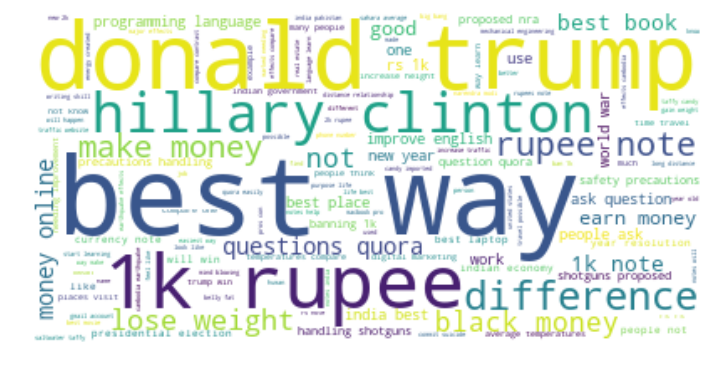

In [32]:
plt.figure(figsize=(12, 8))
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Clouds generated from non duplicate pair question's text

Word Cloud for non-Duplicate Question pairs:


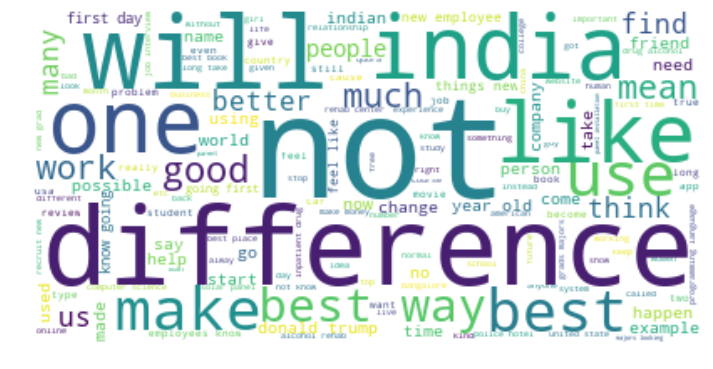

In [33]:
plt.figure(figsize=(12, 8))
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

<Figure size 864x576 with 0 Axes>

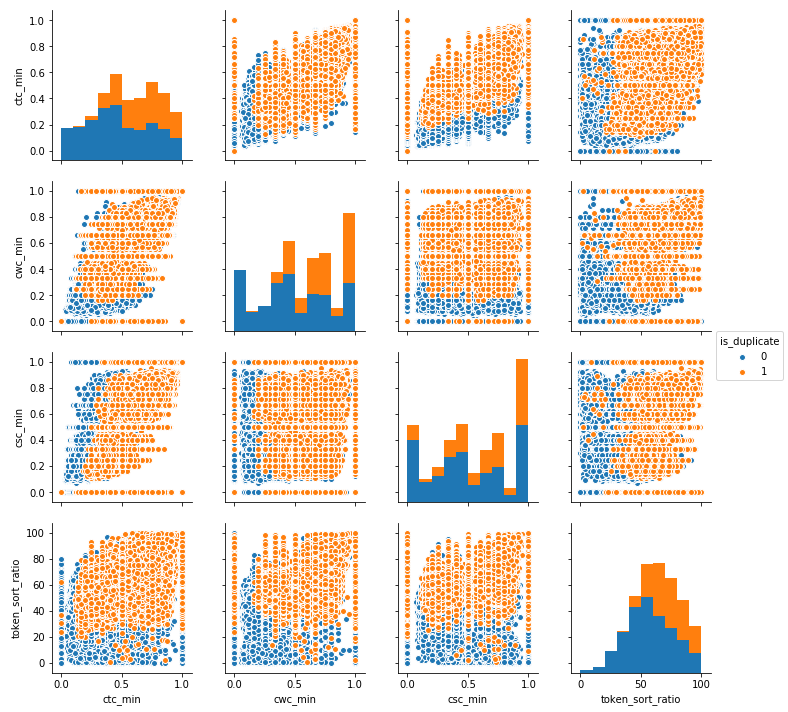

In [34]:
n = df.shape[0]
plt.figure(figsize=(12, 8))
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

#### Distribution of the token_sort_ratio

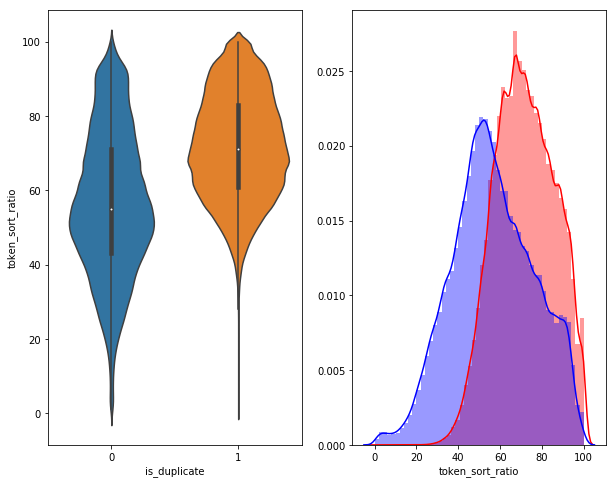

In [35]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

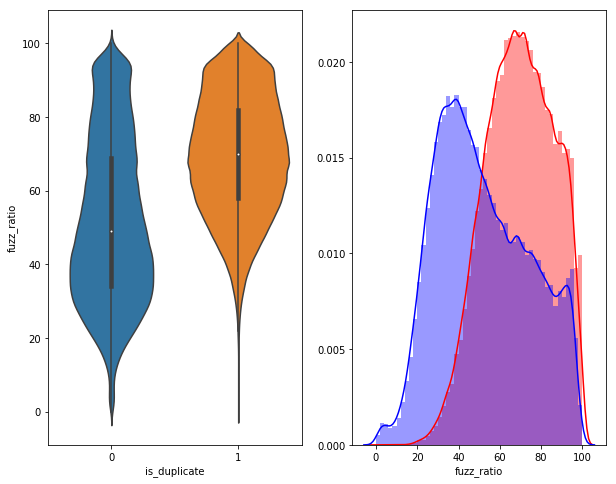

In [36]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [37]:
from datetime import datetime

### Visualization

#### Using TSNE for Dimensionality reduction for 15 Features(Generated after cleaning the data) to 3 dimension

In [38]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [39]:
start = datetime.now()
tsne2d = TSNE(n_components=2,init='random',random_state=101,method='barnes_hut',n_iter=1000,verbose=2,angle=0.5).fit_transform(X)
print('Time taken to process this cell ',datetime.now() - start)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.379s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.207s
[t-SNE] Iteration 50: error = 81.2897949, gradient norm = 0.0455700 (50 iterations in 7.684s)
[t-SNE] Iteration 100: error = 70.6164398, gradient norm = 0.0095177 (50 iterations in 5.958s)
[t-SNE] Iteration 150: error = 68.9172134, gradient norm = 0.0056736 (50 iterations in 5.407s)
[t-SNE] Iteration 200: error = 68.1004639, gradient norm = 0.0049672 (50 iterations in 5.499s)
[t-SNE] Iteration 250: error = 67.5914536, gradient norm = 0.0039700

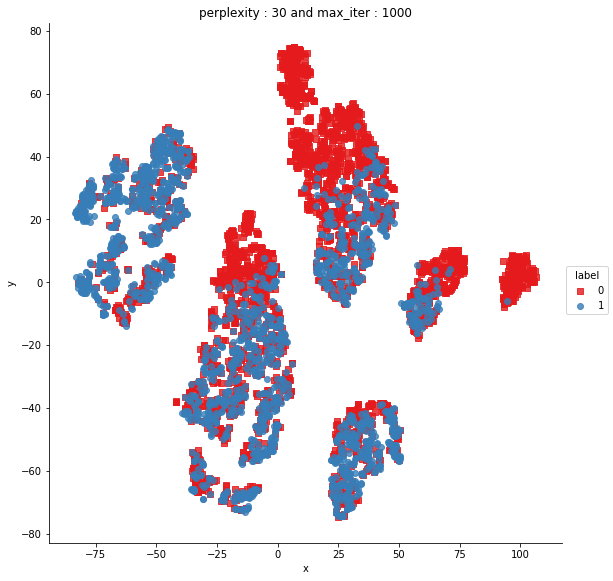

In [40]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [41]:
start = datetime.now()
tsne3d = TSNE(n_components=3,init='random',random_state=101,method='barnes_hut',n_iter=1000,verbose=2,angle=0.5).fit_transform(X)
print('Time taken to process this cell ',datetime.now() - start)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.183s
[t-SNE] Iteration 50: error = 80.5298615, gradient norm = 0.0306586 (50 iterations in 12.548s)
[t-SNE] Iteration 100: error = 69.3777008, gradient norm = 0.0037944 (50 iterations in 6.515s)
[t-SNE] Iteration 150: error = 67.9726028, gradient norm = 0.0017517 (50 iterations in 6.268s)
[t-SNE] Iteration 200: error = 67.4098892, gradient norm = 0.0013384 (50 iterations in 6.300s)
[t-SNE] Iteration 250: error = 67.0977859, gradient norm = 0.000959

###  Featurizing text data with tfidf weighted word-vectors

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy

In [44]:
df = pd.read_csv("all/train.csv")
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [45]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [47]:
len(word2tfidf)

109679

In [48]:
nlp = spacy.load('en')

In [49]:
df['question1'][:1]

0    What is the step by step guide to invest in sh...
Name: question1, dtype: object

In [50]:
q1 = str(df['question1'][:1])
nlp(q1)

0    What is the step by step guide to invest in sh...
Name: question1, dtype: object

In [167]:
nlp = spacy.load('en')

vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 404290/404290 [53:44<00:00, 125.39it/s] 


In [52]:
import pickle
from sklearn.externals import joblib

def save_data(data,file):
    joblib.dump(data,open(file,"wb"))
    
def load_data(file):
    data = joblib.load(open(file,"rb"))
    return data

In [55]:
save_data(list(vecs1),'q1_vecs')

In [54]:
df['q1_feats_m'] = load_data('q1_vecs')

In [170]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [52:48<00:00, 127.58it/s] 


In [171]:
save_data(list(vecs2),'q2_vecs')

In [56]:
df['q2_feats_m'] = load_data('q2_vecs')

In [57]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [58]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate','q1len1','q2len1'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [59]:
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [60]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [61]:
df3.head()

,id,q1_feats_m,q2_feats_m
0,0,"[121.92992651462555, 100.08389979600906, 72.49...","[125.98330092430115, 95.63648450374603, 42.114..."
1,1,"[-78.07093858718872, 54.84378078579903, 82.738...","[-106.87190437316895, 80.29033121466637, 79.06..."
2,2,"[-5.3550145626068115, 73.6718100309372, 14.376...","[7.072874799370766, 15.51337805390358, 1.84691..."
3,3,"[5.778358697891235, -34.71203848719597, 48.999...","[39.4215312898159, 44.13698919117451, -24.0109..."
4,4,"[51.13821983337402, 38.58731163293123, 123.639...","[31.950101375579834, 62.85410565137863, 1.7781..."


In [62]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,...,12.397642,40.909519,8.150261,-15.170692,18.007709,6.166999,-30.124163,3.700902,-1.757693,-1.818058
1,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,...,-21.987077,-12.389279,20.667979,2.202714,-17.142454,-5.880972,-10.123963,-4.890663,-13.018389,-5.219310
2,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,...,3.027700,14.025767,-2.960312,-3.206544,4.355141,2.936152,-20.199555,9.816351,11.894366,-8.798819
3,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,...,13.100007,1.405670,-1.891076,-7.882638,18.000561,12.106918,-10.507835,5.243834,10.158340,5.886351
4,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,...,13.906532,43.461721,11.519207,-22.468284,45.431128,8.161224,-35.373910,7.728865,9.592849,5.447336


In [63]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,125.983301,95.636485,42.114702,95.449980,-37.386295,39.400078,-148.116070,-87.851475,110.371966,62.272814,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,-106.871904,80.290331,79.066297,59.302092,-42.175328,117.616655,-144.364237,-127.131513,22.962533,25.397575,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,7.072875,15.513378,1.846914,85.937583,-33.808811,94.702337,-122.256856,-114.009530,53.922293,60.131814,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,39.421531,44.136989,-24.010929,85.265863,-0.339022,-9.323137,-60.499651,-37.044763,49.407848,-23.350150,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,31.950101,62.854106,1.778164,36.218768,-45.130875,66.674880,-106.342341,-22.901008,59.835938,62.663961,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


In [64]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 384
Number of features in question2 w2v  dataframe : 384
Number of features in final dataframe  : 797


In [65]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

### Fitting the data to various ML models

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [415]:
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 48000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [416]:
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [417]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [418]:
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [419]:
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [420]:
data.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.499975001249937,0.33332222259258,0.249993750156246,0.249993750156246,0.333327777870369,0.285710204139941,1.0,0.0,1.0,6.5,...,5.32290986180306,1.09213811904192,-6.26923231408,-2.56642418820411,8.79581379890442,5.54371391236782,-3.28712978214025,2.39940166473389,1.42706886585802,2.94550034403801
2,0.33332222259258,0.33332222259258,0.749981250468738,0.749981250468738,0.571420408279882,0.571420408279882,1.0,1.0,0.0,7.0,...,2.35969120613299,6.58000134676695,1.83523046644405,-4.36745666339994,-0.899443786591291,-0.571976497769356,-6.27916083484888,13.5579232424498,0.346470408141613,3.6821788996458


In [421]:
a1= data

#### Checking if there is any row with non-numeric values

In [422]:
a1.loc[pd.to_numeric(a1['cwc_min'], errors='coerce').isnull()]

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y


In [104]:
# data.drop(data.index[69128:69129],inplace = True)

In [111]:
# cols = list(data.columns)
# for i in cols:
#     data[i] = data[i].apply(pd.to_numeric)

#### Converting the data type of all numeric values to float

In [423]:
cols = list(data.columns)
data = pd.DataFrame(np.array(data.values,dtype=np.float64),columns=cols)

In [424]:
data.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0.499975,0.333322,0.249994,0.249994,0.333328,0.28571,1.0,0.0,1.0,6.5,...,5.322910,1.092138,-6.269232,-2.566424,8.795814,5.543714,-3.287130,2.399402,1.427069,2.945500
1,0.333322,0.333322,0.749981,0.749981,0.571420,0.57142,1.0,1.0,0.0,7.0,...,2.359691,6.580001,1.835230,-4.367457,-0.899444,-0.571976,-6.279161,13.557923,0.346470,3.682179


In [121]:
# y_true[69128:69129]

69129    is_duplicate
Name: is_duplicate, dtype: object

In [122]:
# y_true.drop(y_true.index[69128:69129],inplace = True)

In [425]:
y_true = list(map(int, y_true.values))

### Random train test split( 70:30)

In [426]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [427]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 794)
Number of data points in test data : (30000, 794)


### Distribution of the duplicate and non-duplicate questions in train and test data

In [428]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print('\n')
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6321428571428571 Class 1:  0.3678571428571429


---------- Distribution of output variable in test data ----------
Class 0:  0.3678666666666667 Class 1:  0.3678666666666667


### Function to plot the Confusion matrix, Precision matrix and Recall Matrix

In [429]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8811967269924282


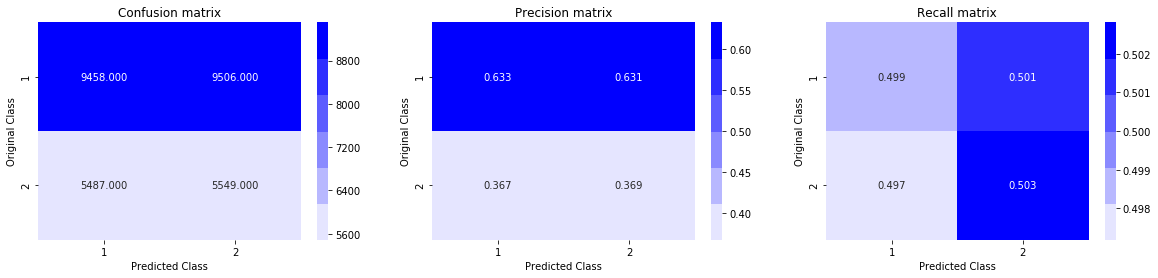

In [430]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Logistic Regression with hyperparameter tuning (Tf-Idf W2V)

In [431]:
start = datetime.now()
alpha = [10 ** x for x in range(-5, 2)]

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

print('Time taken to run this cell',datetime.now() - start)

For values of alpha =  1e-05 The log loss is: 0.6036962919539396
For values of alpha =  0.0001 The log loss is: 0.5190297811344277
For values of alpha =  0.001 The log loss is: 0.5291592657209432
For values of alpha =  0.01 The log loss is: 0.532895376137118
For values of alpha =  0.1 The log loss is: 0.5342581564635732
For values of alpha =  1 The log loss is: 0.511871885700274
For values of alpha =  10 The log loss is: 0.5158061600169807
Time taken to run this cell 0:00:46.636143


### Cross Validation Error for each alpha

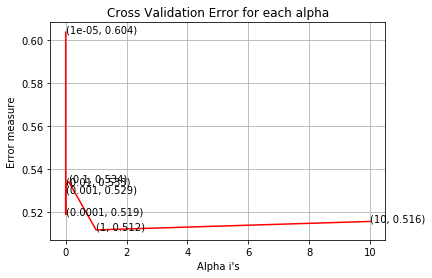

In [432]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='r')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

### Fitting the model to the best alpha that is obtained

In [433]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

For values of best alpha =  1 The train log loss is: 0.5050858781370724
For values of best alpha =  1 The test log loss is: 0.511871885700274
Total number of data points : 30000


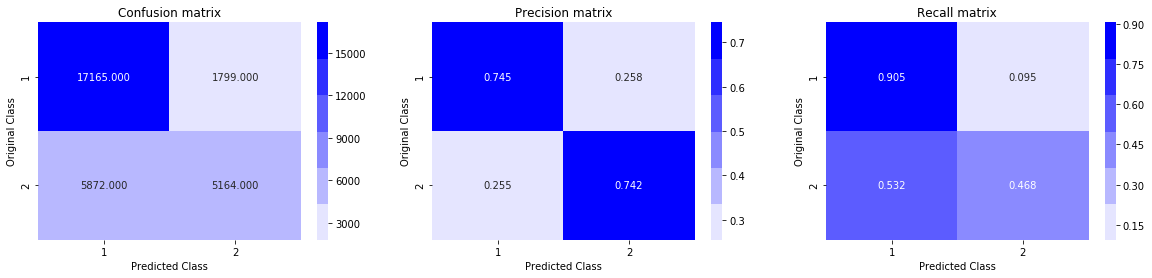

In [434]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM with hyperparameter tuning (Tf-Idf W2V)

In [435]:
start = datetime.now()
alpha = [10 ** x for x in range(-5, 2)]

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    
print('Time taken to run this cell',datetime.now() - start)

For values of alpha =  1e-05 The log loss is: 0.588028141484716
For values of alpha =  0.0001 The log loss is: 0.4860013872005403
For values of alpha =  0.001 The log loss is: 0.5268716864478848
For values of alpha =  0.01 The log loss is: 0.5688494337460287
For values of alpha =  0.1 The log loss is: 0.5969178615229491
For values of alpha =  1 The log loss is: 0.6374790448581448
For values of alpha =  10 The log loss is: 0.6446715990868536
Time taken to run this cell 0:01:07.753567


### Cross Validation Error for each alpha

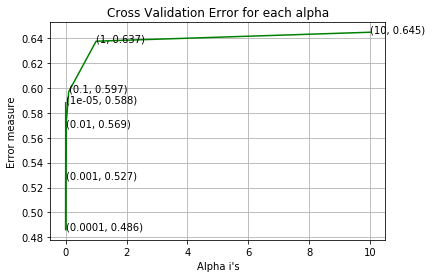

In [436]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

### Fitting the model to the best alpha that is obtained

In [437]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

For values of best alpha =  0.0001 The train log loss is: 0.47824611166892833
For values of best alpha =  0.0001 The test log loss is: 0.4860013872005403
Total number of data points : 30000


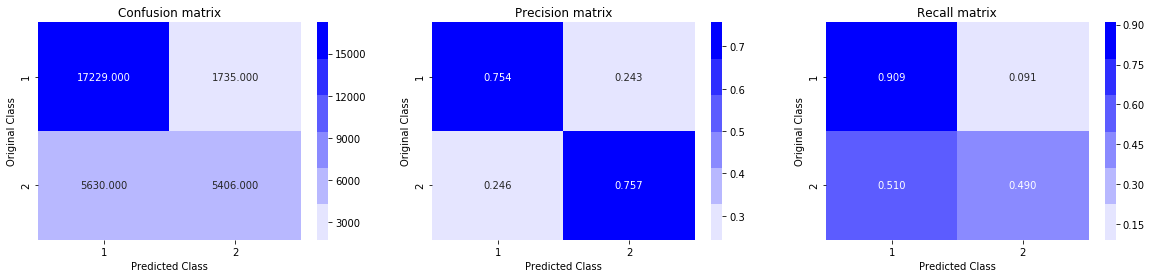

In [438]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### XGBoost (Tf-Idf W2v)

In [97]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

In [98]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

In [99]:
start = datetime.now()
bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=20, verbose_eval=20)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print('Time taken to run this cell',datetime.now() - start)

[08:59:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.684898	valid-logloss:0.684888
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[08:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[09:00:31] src/

Total number of data points : 30000


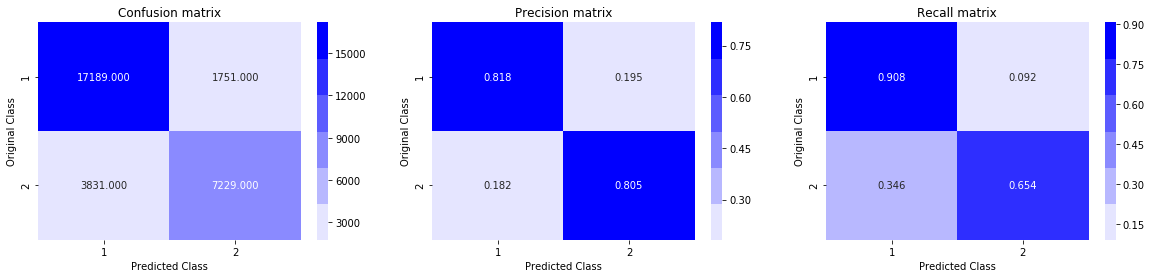

In [100]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Fitting the models to Tf-Idf Vectorized data

In [356]:
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [357]:
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0','index','is_duplicate'], axis=1, inplace=True)

In [358]:
data.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,18487,0.599988000239995,0.374995312558593,0.333327777870369,0.333327777870369,0.384612426058261,0.312498046887207,0.0,0.0,3.0,...,9.66780648333952,6.76019018888474,0.661956481635571,-14.6052718535066,-5.76092050597072,2.56293515861034,-8.39902706444263,21.4107688106596,5.97641041129828,-0.661566495895386
2,226966,0.833319444675922,0.49999500005,0.749990625117186,0.749990625117186,0.785708673509475,0.611107716068244,0.0,1.0,4.0,...,18.0501286685467,42.422396376729,35.453756763367,-14.1211744695902,22.860523596406,-1.84714108705521,-36.5320405475795,9.16784980893135,20.6264977157116,22.4685792066157


In [359]:
cols = list(data.columns)
data = pd.DataFrame(np.array(data.values,dtype=np.float64),columns=cols)

In [360]:
data = data.iloc[:,:26]

In [361]:
data.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2
0,18487.0,0.599988,0.374995,0.333328,0.333328,0.384612,0.312498,0.0,0.0,3.0,...,1.0,1.0,85.0,71.0,16.0,12.0,2.0,24.0,0.083333,2.0
1,226966.0,0.833319,0.499995,0.749991,0.749991,0.785709,0.611108,0.0,1.0,4.0,...,1.0,1.0,77.0,102.0,14.0,18.0,10.0,32.0,0.312500,2.0


In [362]:
data['id'] = data['id'].astype('int')

In [363]:
data.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2
0,18487,0.599988,0.374995,0.333328,0.333328,0.384612,0.312498,0.0,0.0,3.0,...,1.0,1.0,85.0,71.0,16.0,12.0,2.0,24.0,0.083333,2.0
1,226966,0.833319,0.499995,0.749991,0.749991,0.785709,0.611108,0.0,1.0,4.0,...,1.0,1.0,77.0,102.0,14.0,18.0,10.0,32.0,0.312500,2.0


In [364]:
ids = data['id'].values

In [365]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

In [366]:
data['question1'] = dfnlp.iloc[ids]['question1'].values
data['question2'] = dfnlp.iloc[ids]['question2'].values

In [367]:
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))

In [368]:
data.head(2)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,question1,question2
0,18487,0.599988,0.374995,0.333328,0.333328,0.384612,0.312498,0.0,0.0,3.0,...,85.0,71.0,16.0,12.0,2.0,24.0,0.083333,2.0,can astral travel with body be done to visit...,will the future be more peaceful or more viole...
1,226966,0.833319,0.499995,0.749991,0.749991,0.785709,0.611108,0.0,1.0,4.0,...,77.0,102.0,14.0,18.0,10.0,32.0,0.312500,2.0,how can i to prove that a set of logical conne...,how can one prove that a set of logical connec...


### Random train test split (70:30)

In [369]:
x_train,x_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [370]:
print("Shape of train data :",x_train.shape)
print("Shape of test data :",x_test.shape)

Shape of train data : (70000, 28)
Shape of test data : (30000, 28)


### Vectorizing the train and test data using Tf-Idf Vectorizer

In [371]:
tfidf_1 = TfidfVectorizer(lowercase=False)
tfidf_2 = TfidfVectorizer(lowercase=False)

ques_1_train = tfidf_1.fit_transform(x_train['question1'].values)
ques_1_test = tfidf_1.transform(x_test['question1'].values)

ques_2_train = tfidf_2.fit_transform(x_train['question2'].values)
ques_2_test = tfidf_2.transform(x_test['question2'].values)

In [372]:
x_train = x_train.drop(['id'],axis=1)
x_train = x_train.drop(['question1'],axis=1)
x_train = x_train.drop(['question2'],axis=1)

x_test = x_test.drop(['id'],axis=1)
x_test = x_test.drop(['question1'],axis=1)
x_test = x_test.drop(['question2'],axis=1)

In [373]:
from scipy.sparse import hstack

tfidf_x_train = hstack((ques_1_train,ques_2_train))
x_train = hstack((x_train,tfidf_x_train))

tfidf_x_test = hstack((ques_1_test,ques_2_test))
x_test = hstack((x_test,tfidf_x_test))

In [374]:
print('Shape of train data is ',x_train.shape)
print('Shape of test data is ',x_test.shape)

Shape of train data is  (70000, 60678)
Shape of test data is  (30000, 60678)


In [375]:
from sklearn.preprocessing import Normalizer
normalizer  = Normalizer()
x_train = normalizer.fit_transform(x_train)
x_test = normalizer.transform(x_test)

In [396]:
y_train = y_train.apply(lambda x: int(x))
y_test = y_test.apply(lambda x: int(x))

### Logistic Regression with hyperparameter tuning (Tf-Idf)

In [402]:
start = datetime.now()
alpha = [10 ** x for x in range(-14, 2)]

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

print('Time taken to run this cell',datetime.now() - start)

For values of alpha =  1e-14 The log loss is: 0.47500364963886654
For values of alpha =  1e-13 The log loss is: 0.4730025344284249
For values of alpha =  1e-12 The log loss is: 0.4713020299013947
For values of alpha =  1e-11 The log loss is: 0.47077978752729954
For values of alpha =  1e-10 The log loss is: 0.4698808526844432
For values of alpha =  1e-09 The log loss is: 0.468412788912706
For values of alpha =  1e-08 The log loss is: 0.4714658259494925
For values of alpha =  1e-07 The log loss is: 0.4713535152817609
For values of alpha =  1e-06 The log loss is: 0.470490333309153
For values of alpha =  1e-05 The log loss is: 0.4831605959706975
For values of alpha =  0.0001 The log loss is: 0.5118970760941151
For values of alpha =  0.001 The log loss is: 0.5495987871614764
For values of alpha =  0.01 The log loss is: 0.5794211187891898
For values of alpha =  0.1 The log loss is: 0.5910308588197919
For values of alpha =  1 The log loss is: 0.6107059625384548
For values of alpha =  10 The l

### Cross Validation Error for each alpha

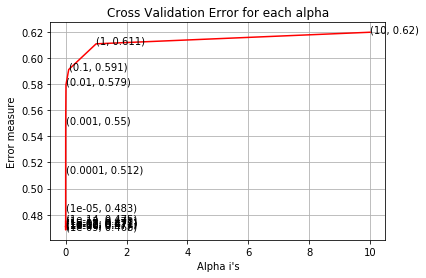

In [403]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='r')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

### Fitting the model to the best alpha value that is obtained

In [404]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-09, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

For values of best alpha =  1e-09 The train log loss is: 0.4674269408553449
For values of best alpha =  1e-09 The test log loss is: 0.468412788912706
Total number of data points : 30000


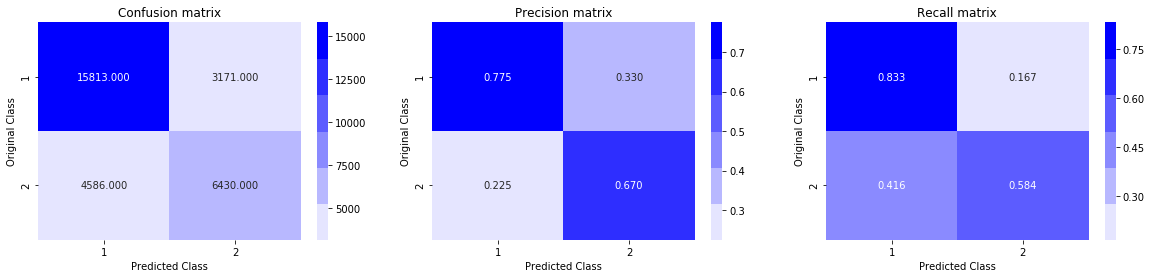

In [405]:
predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM with hyperparameter tuning (Tf-Idf)

In [397]:
start = datetime.now()
alpha = [10 ** x for x in range(-14,2)]

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    
print('Time taken to run this cell',datetime.now() - start)

For values of alpha =  1e-14 The log loss is: 0.46864742408752424
For values of alpha =  1e-13 The log loss is: 0.47128208062402727
For values of alpha =  1e-12 The log loss is: 0.4770671258713501
For values of alpha =  1e-11 The log loss is: 0.47281206872160536
For values of alpha =  1e-10 The log loss is: 0.4687074385857999
For values of alpha =  1e-09 The log loss is: 0.4710268108208345
For values of alpha =  1e-08 The log loss is: 0.47169083359380953
For values of alpha =  1e-07 The log loss is: 0.4664101823801624
For values of alpha =  1e-06 The log loss is: 0.46397905899161473
For values of alpha =  1e-05 The log loss is: 0.47343386501855267
For values of alpha =  0.0001 The log loss is: 0.48829653766094827
For values of alpha =  0.001 The log loss is: 0.5461906322241178
For values of alpha =  0.01 The log loss is: 0.5753673184260824
For values of alpha =  0.1 The log loss is: 0.5977378178286804
For values of alpha =  1 The log loss is: 0.657448639597645
For values of alpha =  10

### Cross Validation Error for each alpha

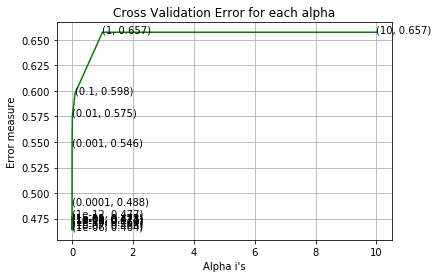

In [398]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

### Fitting the model to the best alpha value that is obtained

In [399]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-06, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

For values of best alpha =  1e-06 The train log loss is: 0.4633136027307924
For values of best alpha =  1e-06 The test log loss is: 0.46397905899161473
Total number of data points : 30000


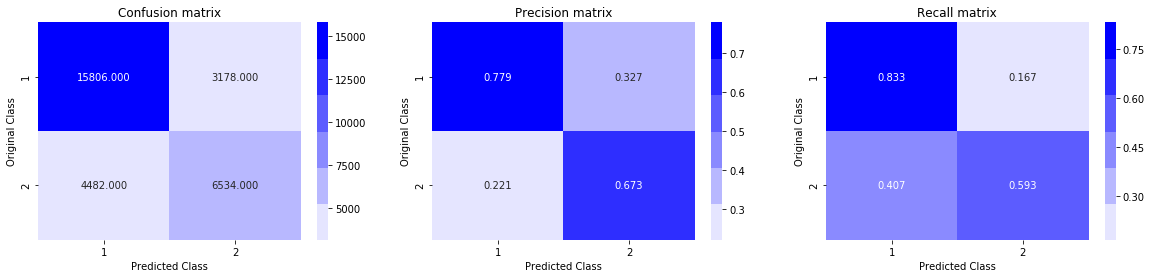

In [401]:
predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Xgboost with Hyperparameter tuning (Tf-Idf)

In [406]:
params = {}
params['max_depth'] = np.arange(2,10,2)
params['min_child_weight'] = np.arange(1,4)
params['learning_rate'] = [0.01,0.03,0.1,0.2,0.4]

fit_parameters = {}
fit_parameters['eval_metric'] = 'logloss'

### Random Search CV to select the best hyperparameter

In [407]:
from sklearn.model_selection import RandomizedSearchCV

classifier = xgb.XGBClassifier(n_jobs=-1)

random_search = RandomizedSearchCV(classifier,param_distributions =params, n_iter=30,n_jobs=-1, verbose=2, cv=3,fit_params=fit_parameters,scoring='log_loss', refit=False, random_state=42)


In [408]:
start = datetime.now()
random_search.fit(x_train, y_train)
print('Time taken to run this cell ',datetime.now() - start)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] min_child_weight=1, max_depth=2, learning_rate=0.01 .............
[CV] min_child_weight=1, max_depth=2, learning_rate=0.01 .............
[CV] min_child_weight=1, max_depth=2, learning_rate=0.01 .............
[CV] min_child_weight=3, max_depth=4, learning_rate=0.01 .............
[CV] min_child_weight=3, max_depth=4, learning_rate=0.01 .............
[CV] min_child_weight=3, max_depth=4, learning_rate=0.01 .............
[CV] min_child_weight=1, max_depth=2, learning_rate=0.2 ..............
[CV] min_child_weight=1, max_depth=2, learning_rate=0.2 ..............
[CV]  min_child_weight=1, max_depth=2, learning_rate=0.2, total=  48.0s
[CV]  min_child_weight=1, max_depth=2, learning_rate=0.01, total=  48.7s
[CV] min_child_weight=1, max_depth=2, learning_rate=0.2 ..............
[CV] min_child_weight=1, max_depth=8, learning_rate=0.2 ..............
[CV]  min_child_weight=1, max_depth=2, learning_rate=0.2, total=  48.2s
[CV] min_chi

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.5min


[CV]  min_child_weight=1, max_depth=2, learning_rate=0.03, total=  48.0s
[CV] min_child_weight=3, max_depth=2, learning_rate=0.4 ..............
[CV]  min_child_weight=3, max_depth=2, learning_rate=0.4, total=  41.4s
[CV] min_child_weight=3, max_depth=2, learning_rate=0.4 ..............
[CV]  min_child_weight=1, max_depth=8, learning_rate=0.1, total= 2.9min
[CV] min_child_weight=3, max_depth=2, learning_rate=0.4 ..............
[CV]  min_child_weight=3, max_depth=2, learning_rate=0.4, total=  48.1s
[CV] min_child_weight=2, max_depth=6, learning_rate=0.1 ..............
[CV]  min_child_weight=1, max_depth=8, learning_rate=0.4, total= 2.8min
[CV] min_child_weight=2, max_depth=6, learning_rate=0.1 ..............
[CV]  min_child_weight=1, max_depth=8, learning_rate=0.4, total= 2.9min
[CV] min_child_weight=2, max_depth=6, learning_rate=0.1 ..............
[CV]  min_child_weight=3, max_depth=2, learning_rate=0.4, total=  45.9s
[CV] min_child_weight=1, max_depth=4, learning_rate=0.01 ............

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 22.3min finished


Time taken to run this cell  0:22:21.834992


In [409]:
random_search.best_score_

-0.33913618759088476

In [410]:
best_params = random_search.best_params_
best_params

{'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.2}

### Training the classifier on the best hyperparameters that are obtained

Log loss for tfidf train data :  0.2707769918545841
Log loss for tfidf test data :  0.3422785331868313


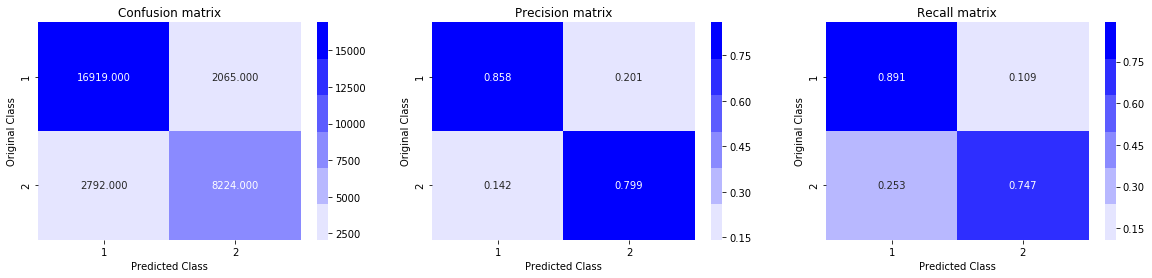

In [411]:
clf = xgb.XGBClassifier(max_depth=best_params['max_depth'],learning_rate=best_params['learning_rate'],objective='binary:logistic',min_child_weight=best_params['min_child_weight'],n_estimators=100,eval_metric='logloss',n_jobs=-1)
clf.fit(x_train, y_train)                      
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)
predict_y = sig_clf.predict_proba(x_train)
print("Log loss for tfidf train data : ",log_loss(y_train, predict_y,  eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print("Log loss for tfidf test data : ",log_loss(y_test, predict_y,  eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Observations

| Model | Type of Featurization  | Train Log Loss | Test Log Loss |
|--|--| -- | -- |
|Logistic Regression| Tf-Idf W2V|0.505  |  0.511|
|Linear SVM| Tf-Idf W2V |0.478 |0.486 |
|XGBoost| Tf-Idf W2V |0.373 |0.375 |
|Logistic Regression| Tf-Idf| 0.467 | 0.468 |
|Linear SVM| Tf-Idf |0.463 |0.463 |
|XGBoost (with hyperparameter tuning)| Tf-Idf |0.270 |0.342 |

**It can be seen that XGBoost with hyperparameter tuning performed well as compared to other models with a test log loss of 0.342**